In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds
import scipy.stats

In [2]:
def get_inf(beta,scale,duration, gamma = 1/14):
    """
    input: beta, scale parameters, duration - numbers of days we want to consider, gamma - fixed value
    output: list of infections rates
    
    """
    Dt = 0.01    # timestep Delta t
    S_start=99.9    #healthy but can be infected 
    I_start=0.1    #infectious (the actual number isn't relevant as long as it's small)
    R_start=0    #recovered
    N=S_start+I_start+R_start    # total population is constant
    t_start = 0      
    t_end = duration
    n_steps = int(round((t_end-t_start)/Dt))    # number of timesteps

    #initial arrays we fill with data for each 0.01 of day
    S_arr = np.zeros(n_steps +1)
    I_arr = np.zeros(n_steps +1)
    R_arr=np.zeros(n_steps +1)
    t_arr = np.zeros(n_steps + 1) 
    
    #initialise starting parameters
    t_arr[0] = t_start    
    S_arr[0] =S_start   
    I_arr[0]=I_start
    R_arr[0]=R_start

    # Euler's method
    for i in range (1, n_steps + 1):  
            S = S_arr[i-1]
            I = I_arr[i-1]
            R = R_arr[i-1]
            t = t_arr[i-1]
            dSdt = - beta * I * S / N          
            dIdt = beta * I * S / N - gamma * I
            dRdt = gamma * I

            S_arr[i] = S + Dt * dSdt  # calculate  at next timestep, add to array
            I_arr[i] = I + Dt * dIdt
            R_arr[i] = R + Dt * dRdt
            t_arr[i] = t + Dt   # add new value of t to array
          
    return I_arr * scale

In [35]:
# we use a moving average as daily data is too noisy due to the data collection issues
def movavg(data):
    
    return [np.mean(data[i-7:i]) for i in range(7,len(data))]


def get_SSR(x):
    """
    input: beta, scale parameters, start and end date as index of data list
    output: SSR
    
    """
    beta = x[0]
    scale = x[1]
    start = x[2]
    end=x[3]
    #level = x[4] # we decided not to add more parameters as it's clearly overfitting
    cases = netherlands['New_cases'][int(start):int(end)].values
    cases = list(map(lambda x: x/(max(cases)-min(cases)) , cases )) # scaling

    num_inf = movavg(cases) # smoothing data
    theory_num = get_inf(beta=beta,scale=scale,duration=len(num_inf), gamma = 1/14) #theoretical points
    theory_num=theory_num[::100][1:] #we had 100 points a day, need one

    return  (np.sum([(num_inf[i]-theory_num[i])**2 for i in range(len(num_inf))]))

    
def do_all(start=10, end=90, margin = 5):
    """
    input: start and end dates (as positions in dates list)
            margin - how much we allow algorith to move specified piece
    output: optimisation result, graph, and some descriptive statistics
    
    """
    start_values=[start - margin, start + margin] # allowed values
    end_values=[end - margin,end+margin]
    
    # some constraints to simplify optimisation. In fact none of them is binding
    bounds = Bounds((0, 0, start_values[0], end_values[0] ), (1.0, 0.08, start_values[1],end_values[1]))
    
    result = minimize(get_SSR, x0=[0.3,0.03,(start_values[0]+start_values[1])/2,(end_values[0]+end_values[1])/2],
                       method='L-BFGS-B', bounds = bounds)
    opt_param = result['x']
    
    # get exact piece selected
    cases = netherlands['New_cases'][int(opt_param[2]):int(opt_param[3])].values
    cases = list(map(lambda x: x/(max(cases)-min(cases)) , cases ))
    theory_num = get_inf(beta=opt_param[0],scale=opt_param[1],duration=-int(opt_param[2])+int(opt_param[3]))
    x=theory_num[::100][1:]
    
    # plotting
    fig = plt.figure(figsize=(15, 10), dpi=80) 
    plt.plot(range(len(movavg(cases))) ,movavg(cases), linewidth = 4)
    
    #plt.title('Figure 3. Fitted curve and weekly moving average for netherlands no measures', fontsize = 20)    
    plt.xlabel('time (in days)', fontsize = 20)
    plt.ylabel('share of infections', fontsize = 20)
    plt.plot(x, linewidth = 4 )
    plt.show()

    print('SSR = n* flatterness = '+str(get_SSR(opt_param))) # get SSR
    
    # we don't use this statistics here, but can be interesting to look at
    
    #pearson_chisq= np.sum([((movavg(cases)[i] - x[i])/ x[i])**2 for i in range(len(movavg(cases)))])
    #print('pearson_chisq ' + str(pearson_chisq))
    #GTest = 2* np.sum([movavg(cases)[i]*np.log(movavg(cases)[i]/x[i]) for i in range(len(movavg(cases)))])
    #print("GTest " + str(GTest))
    


def get_beta_flatterness(start=10, end=90, margin = 5): 
    """
    input: start and end dates 
            margin - how much we allow algorith to move specified piece
    output: value of optimal beta and flatterness - standart error of fit
    
    """ 
    start_values=[start - margin, start + margin]
    end_values=[end - margin,end+margin]
    bounds = Bounds((0, 0, start_values[0], end_values[0] ), (1.0, 0.08, start_values[1],end_values[1]))
    result = minimize(get_SSR, x0=[0.3,0.03,(start_values[0]+start_values[1])/2,(end_values[0]+end_values[1])/2],
                      method='L-BFGS-B', bounds = bounds)

    opt_param = result['x']
    cases = netherlands['New_cases'][int(opt_param[2]):int(opt_param[3])].values
    cases = list(map(lambda x: x/(max(cases)-min(cases)) , cases ))
    theory_num = get_inf(beta=opt_param[0],scale=opt_param[1],duration=-int(opt_param[2])+int(opt_param[3]))
    x=theory_num[::100][1:]
    SE = get_SSR(opt_param)/len(cases) # standart errors

    return opt_param[0], SE



In [4]:
df = pd.read_csv(r"C:\Users\Dima\Downloads\WHO-COVID-19-global-data (1).csv") #read file wit data
netherlands = df[df['Country']=='Netherlands'] #select country
dates = list(netherlands['Date_reported'].values) #initialise dates
netherlands.describe()


,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,505.000000,5.050000e+02,505.000000,505.000000
mean,3199.009901,4.283947e+05,34.665347,7858.156436
std,3349.232357,5.145278e+05,41.438385,5537.642731
min,0.000000,0.000000e+00,0.000000,0.000000
25%,177.000000,4.151300e+04,2.000000,5252.000000
50%,1234.000000,7.841200e+04,19.000000,6248.000000
75%,5868.000000,8.945700e+05,55.000000,12740.000000
max,12997.000000,1.615500e+06,231.000000,17506.000000


Optimisition above is a bit unusual because we don't have explanatory variables. So we estimate $y = f(\beta)+\epsilon$, where $f(\beta)$ set of points of infected people for possible set of parameteres and $y$ is the actual number of infected people. We'll just minimise SSR over $\beta$. It makes sense: to get some intuition behind what we do try to find an estimator of mean of random variables by setting it as an unnknown variable $\mu$ and minimising SSR. You'll get $\mu = \bar{x}$

In [5]:
print( get_beta_flatterness (dates.index('2020-03-06'), dates.index('2020-05-11')))
print(get_beta_flatterness (dates.index('2020-08-11'), dates.index('2020-11-16')))
print(get_beta_flatterness (dates.index('2020-11-30'), dates.index('2021-02-07')))
print(get_beta_flatterness (dates.index('2021-02-07'), dates.index('2021-05-19')))


(0.37601725322920626, 0.02635176277203664)
(0.16883984474243938, 0.00214080775421206)
(0.5711485901695152, 0.10815729662353114)
(0.1922767548086329, 0.12264061352251253)


In [40]:
# remember flatterness parameteres
c1 = get_beta_flatterness (dates.index('2020-03-06'), dates.index('2020-05-11'))[1]
c2 = get_beta_flatterness (dates.index('2020-08-11'), dates.index('2020-11-16'))[1]
c3 = get_beta_flatterness (dates.index('2020-11-30'), dates.index('2021-02-07'))[1]
c4 = get_beta_flatterness (dates.index('2021-02-07'), dates.index('2021-05-19'))[1]

d1 = get_beta_flatterness (dates.index('2020-02-27'), dates.index('2020-05-11'))[1]
d2 = get_beta_flatterness (dates.index('2020-05-12'), dates.index('2020-11-16'))[1]
d3 = get_beta_flatterness (dates.index('2020-11-17'), dates.index('2021-02-07'))[1]
d4 = get_beta_flatterness (dates.index('2021-02-08'), dates.index('2021-05-19'))[1]

In [46]:
# squared norm of x
def HH(x):
    return (sum([i**2 for i in x]))

# derivative of vector x
def dHH(x):
    return 2*x

cons = [{'type': 'eq', 'fun': lambda x: 0.93*x[0]+0.91*x[1]+0.8*x[2]-c1 },
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+0.92*x[3]-c2 },
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+0.85*x[5]+0.68*x[6]-c3},
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+0.89*x[5]+0.5*x[7]-c4}]

cons1 = [{'type': 'eq', 'fun': lambda x: 0.82*x[0]+0.78*x[1]+0.74*x[2]-c1 },
        {'type': 'eq', 'fun': lambda x: x[0]+0.3*x[1]+x[2]-c2 },
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+0.7*x[4]+0.2*x[5]-c3},
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+0.5*x[5]+0.5*x[6]-c4}]

cons2 = [{'type': 'eq', 'fun': lambda x: 0.93*x[0]+0.91*x[1]+0.8*x[2]-c1 },
        {'type': 'eq', 'fun': lambda x: x[0]+0.6*x[1]+x[2]-c2 },
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+0.85*x[5]+0.7*x[6]-c3},
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+0.8*x[4]+0.42*x[5]+0.25*x[7]-c4}]

#set initial values randomly and by running it several times we can be almost sure there is one optimal point
y_0 = [np.random.normal() for i in range(8)]
y_1 =  [np.random.normal() for i in range(8)]

ssoln = scipy.optimize.minimize(HH, y_0, jac=dHH, method='SLSQP', constraints=cons)
print(ssoln)

     fun: 0.008593038049400323
     jac: array([ 0.02492967,  0.02278388,  0.010982  , -0.05914558,  0.12145312,
        0.1077728 ,  0.00544798,  0.05672069])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.01246484,  0.01139194,  0.005491  , -0.02957279,  0.06072656,
        0.0538864 ,  0.00272399,  0.02836035])


In [44]:
ssoln = scipy.optimize.minimize(HH, y_1, jac=dHH, method='SLSQP', constraints=cons1)
print(ssoln)

     fun: 0.006677801445891559
     jac: array([ 2.11121072e-02, -2.70587274e-02,  3.16199101e-02,  5.24960407e-02,
        9.28144630e-02,  6.65664433e-02,  9.34453909e-02, -6.12622453e-12])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 1.05560536e-02, -1.35293637e-02,  1.58099550e-02,  2.62480203e-02,
        4.64072315e-02,  3.32832217e-02,  4.67226954e-02, -3.06311226e-12])


In [45]:

ssoln = scipy.optimize.minimize(HH, y_0, jac=dHH, method='SLSQP', constraints=cons2)
print(ssoln)

     fun: 0.010381353155546702
     jac: array([-0.01814019,  0.12008478, -0.04962907,  0.11426674,  0.07578586,
        0.01439284, -0.05469636,  0.0481011 ])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([-0.00907009,  0.06004239, -0.02481453,  0.05713337,  0.03789293,
        0.00719642, -0.02734818,  0.02405055])


In [8]:
def sum_of_squares_for_measures(x):
    one = 0.93*x[0]+0.91*x[1]+0.8*x[2]-c1
    two = x[0]+x[1]+x[2]+0.92*x[3]-c2
    three=x[0]+x[1]+x[2]+x[3]+x[4]+0.85*x[5]+0.68*x[6]-c3
    four = x[0]+x[1]+x[2]+x[3]+x[4]+0.89*x[5]+0.5*x[7]-c4
    return (one**2+two**2+three**2+four**2)
#weights? = number of days 
# dates for waves - revise

NameError: name 'x' is not defined

In [10]:
def HH(x):
    return (sum([abs(i) for i in x]))

def dHH(x):
    return 2*x

cons = [{'type': 'eq', 'fun': lambda x: 0.82*x[0]+0.78*x[1]+0.74*x[2]-c1 },
        {'type': 'eq', 'fun': lambda x: x[0]+0.5*x[1]+x[2]+0.5*x[3]-c2 },
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+0.8*x[4]+0.7*x[5]+0.2*x[6]-c3},
        {'type': 'eq', 'fun': lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+0.5*x[6]+0.5*x[7]-c4}]

y_0 = [np.random.normal() for i in range(8)]

ssoln = scipy.optimize.minimize(HH, y_0, jac=dHH, method='SLSQP', constraints=cons)
print(ssoln)

     fun: 0.21443651927870216
     jac: array([-0.0232554 ,  0.12626743, -0.03610221,  0.00101104,  0.10917221,
        0.08527967,  0.00680103, -0.04098404])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([-0.0116277 ,  0.06313372, -0.01805111,  0.00050552,  0.0545861 ,
        0.04263984,  0.00340052, -0.02049202])


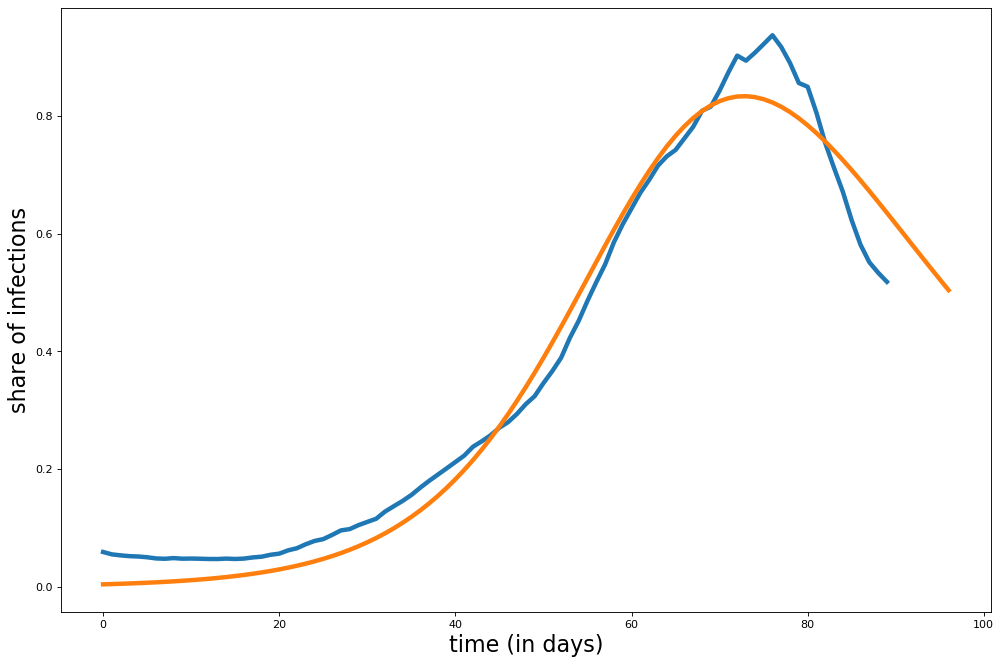

SSR = n* flatterness = 0.20765835215856984
None


In [30]:
#low flatterness piece
print(do_all (dates.index('2020-08-11'), dates.index('2020-11-16')))

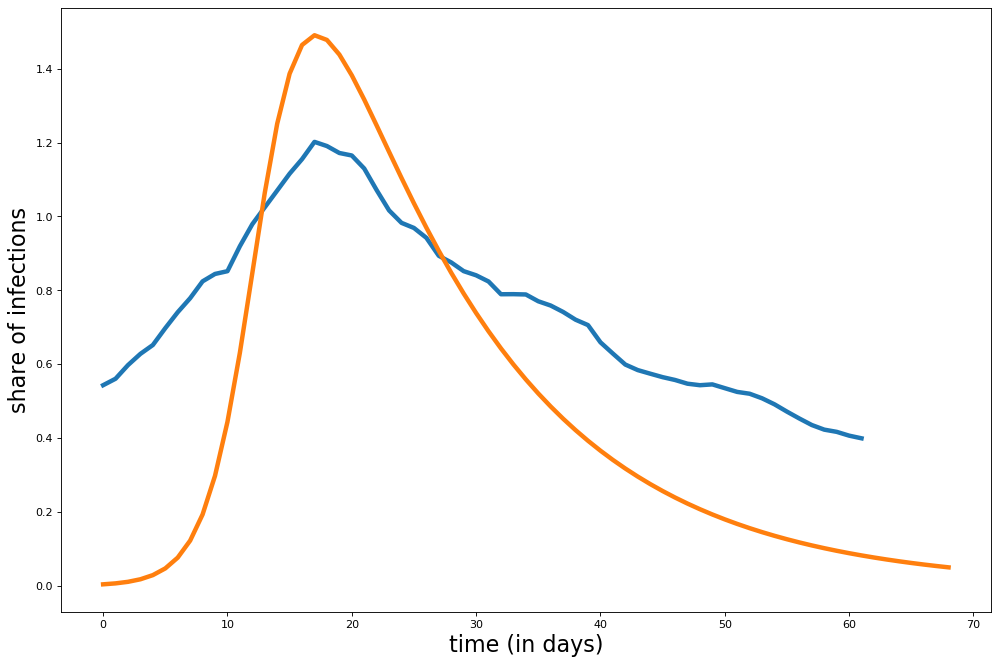

SSR = n* flatterness = 7.462853467023649
None


In [36]:
#high flatterness piece
print (do_all (dates.index('2020-11-30'), dates.index('2021-02-07')))